In [37]:
import os
from dask.distributed import Client
import intake
import xarray as xr

# 1) Dask client
client = Client(n_workers=4, threads_per_worker=1, memory_limit="2GB")

# 2) Output directory
out_dir = r"D:\Downloads"
os.makedirs(out_dir, exist_ok=True)

# 3) Open the catalog
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# 4) Variables to pull
daily_vars = ["tas", "hurs", "sfcWind", "rsds", "rlds", "rsus", "rlus", "pr"]

# 5) Build the query
q = cat.search(
    source_id     = "CESM2",
    experiment_id = "historical",
    table_id      = "day",
    member_id     = "r2i1p1f1",
    variable_id   = daily_vars
)

# 6) Slice on open
def preprocess(ds):
    return ds.sel(
        time=slice("1940-01-01","2014-12-31"),
        lat = slice(32,49),
        lon = slice(235,260)
    )

# 7) Load with consolidated metadata + anonymous GCS access
ds_map = q.to_dataset_dict(
    storage_options={"token": "anon", "cache": True},  # ← must be top‑level
    zarr_kwargs={"consolidated": True},
    xarray_open_kwargs={"engine": "zarr"},
    xarray_combine_by_coords_kwargs={"compat": "override"},
    preprocess=preprocess
)

# 8) Merge & drop singleton dims
key = list(ds_map.keys())[0]
ds = ds_map[key].squeeze(["member_id", "dcpp_init_year"], drop=True)

# 9) Drop the CF “bounds” var on time (so we don’t have to chunk it)
time_bnds = ds.time.attrs.get("bounds")
if time_bnds and time_bnds in ds:
    ds = ds.drop_vars(time_bnds)

# 10) Rechunk by year
ds = ds.chunk({
    "time": 365,
    "lat":  ds.sizes["lat"],
    "lon":  ds.sizes["lon"]
})

# 11) Build encoding ONLY for your daily_vars
encoding = {}
for var in daily_vars:
    # get the first chunk size along each axis
    chunk_shape = tuple(dim_chunks[0] for dim_chunks in ds[var].chunks)
    encoding[var] = {"chunks": chunk_shape}

# 12) Write out with explicit encoding (no chunk-overlap)
out_path = os.path.join(out_dir, "CESM2_r2i1p1f1_day_WUS_1940_2014.zarr")
ds.to_zarr(
    out_path,
    mode="w",               # overwrite if it exists
    consolidated=True,
    encoding=encoding
)

print("Wrote:", out_path)

c:\Users\srira\.conda\envs\CESM2\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 9741 instead
  warnings.warn(
c:\Users\srira\.conda\envs\CESM2\lib\contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (4.57s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Wrote: D:\Downloads\CESM2_r2i1p1f1_day_WUS_1940_2014.zarr


C:\Users\srira\AppData\Local\Temp\ipykernel_15644\3489869779.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


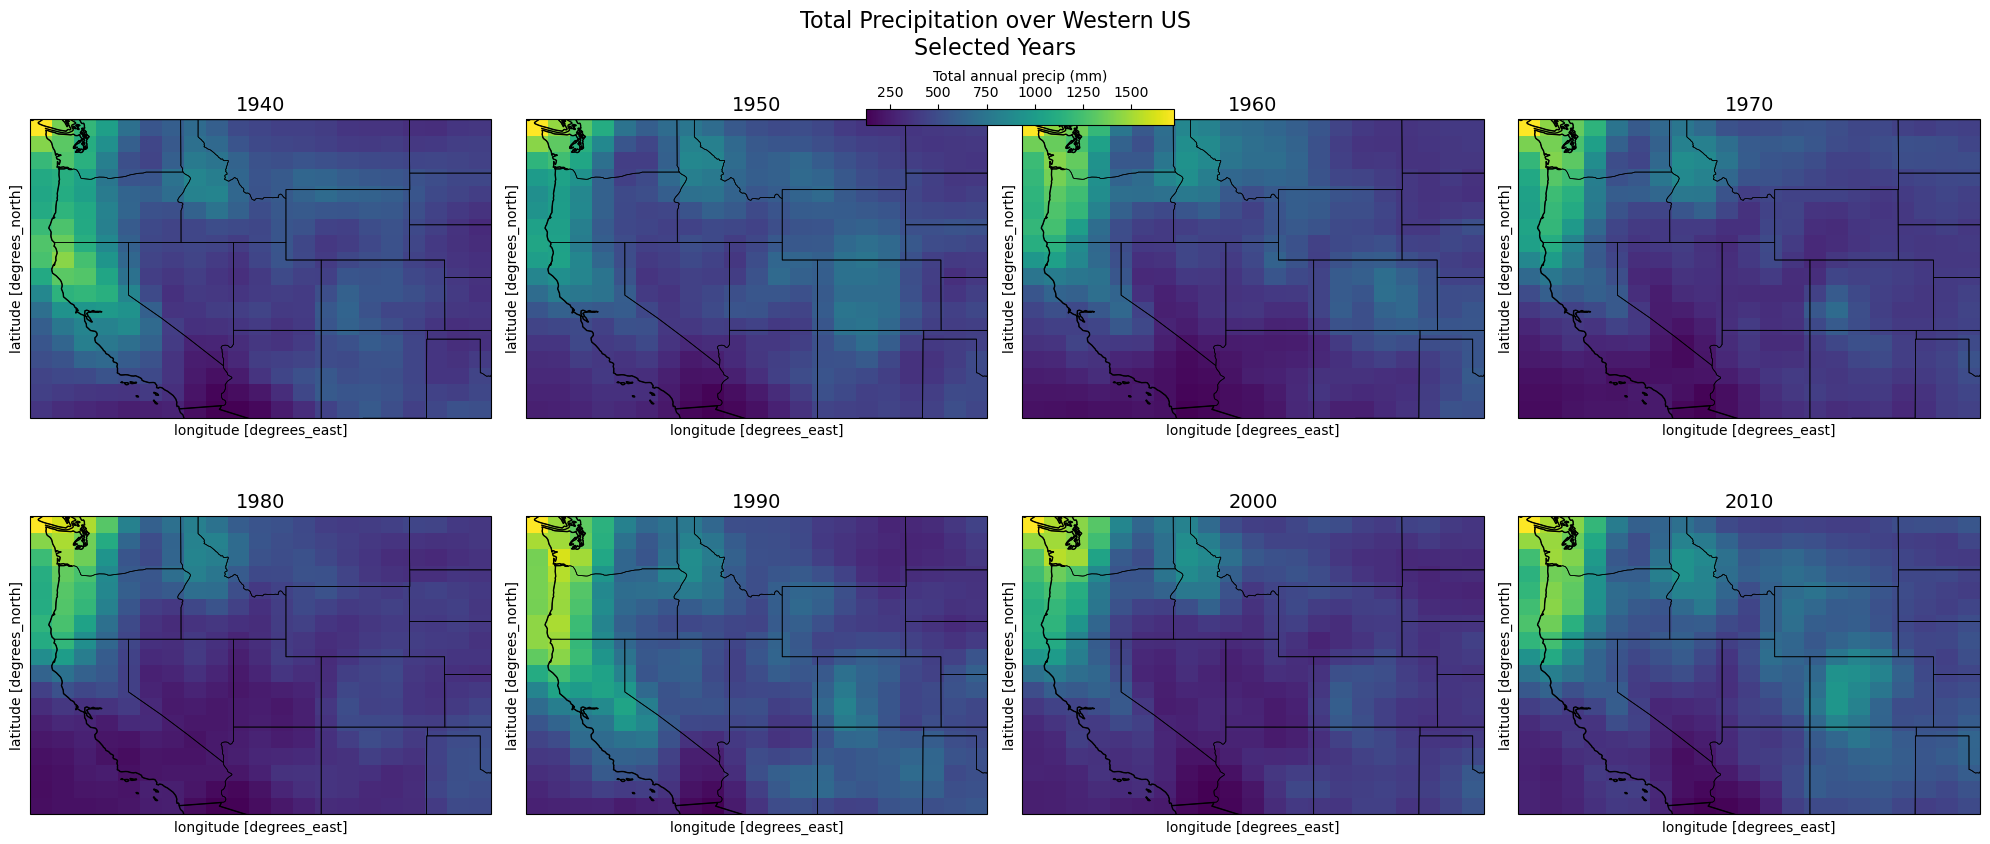

In [38]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import zarr

# 1. Open the Zarr store
zarr_path = r"D:\Downloads\CESM2_r2i1p1f1_day_WUS_1940_2014.zarr"
store = zarr.storage.DirectoryStore(zarr_path)
ds = xr.open_zarr(store, consolidated=True)

# Years to plot
years = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

# Prepare figure: 2 rows × 4 cols
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    nrows=2, ncols=4,
    figsize=(20, 10),
    subplot_kw={'projection': proj}
)

for ax, year in zip(axes.flat, years):
    # 2. Select pr for that year
    pr_year = ds['pr'].sel(
        time=slice(f'{year}-01-01', f'{year}-12-31')
    )
    # 3. Compute total annual precip (mm)
    total_pr = pr_year.sum(dim='time') * 86400

    # 4. Plot it
    img = total_pr.plot.pcolormesh(
        ax=ax,
        transform=proj,
        cmap='viridis',
        add_colorbar=False
    )
    # Overlay boundaries
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
    ax.set_title(f'{year}', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

# Shared colorbar
cbar = fig.colorbar(
    img, ax=axes.ravel().tolist(),
    orientation='horizontal', fraction=0.02, pad=0.01, location='top'
)
cbar.set_label('Total annual precip (mm)')

fig.suptitle('Total Precipitation over Western US\nSelected Years', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\srira\AppData\Local\Temp\ipykernel_15644\3609639189.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


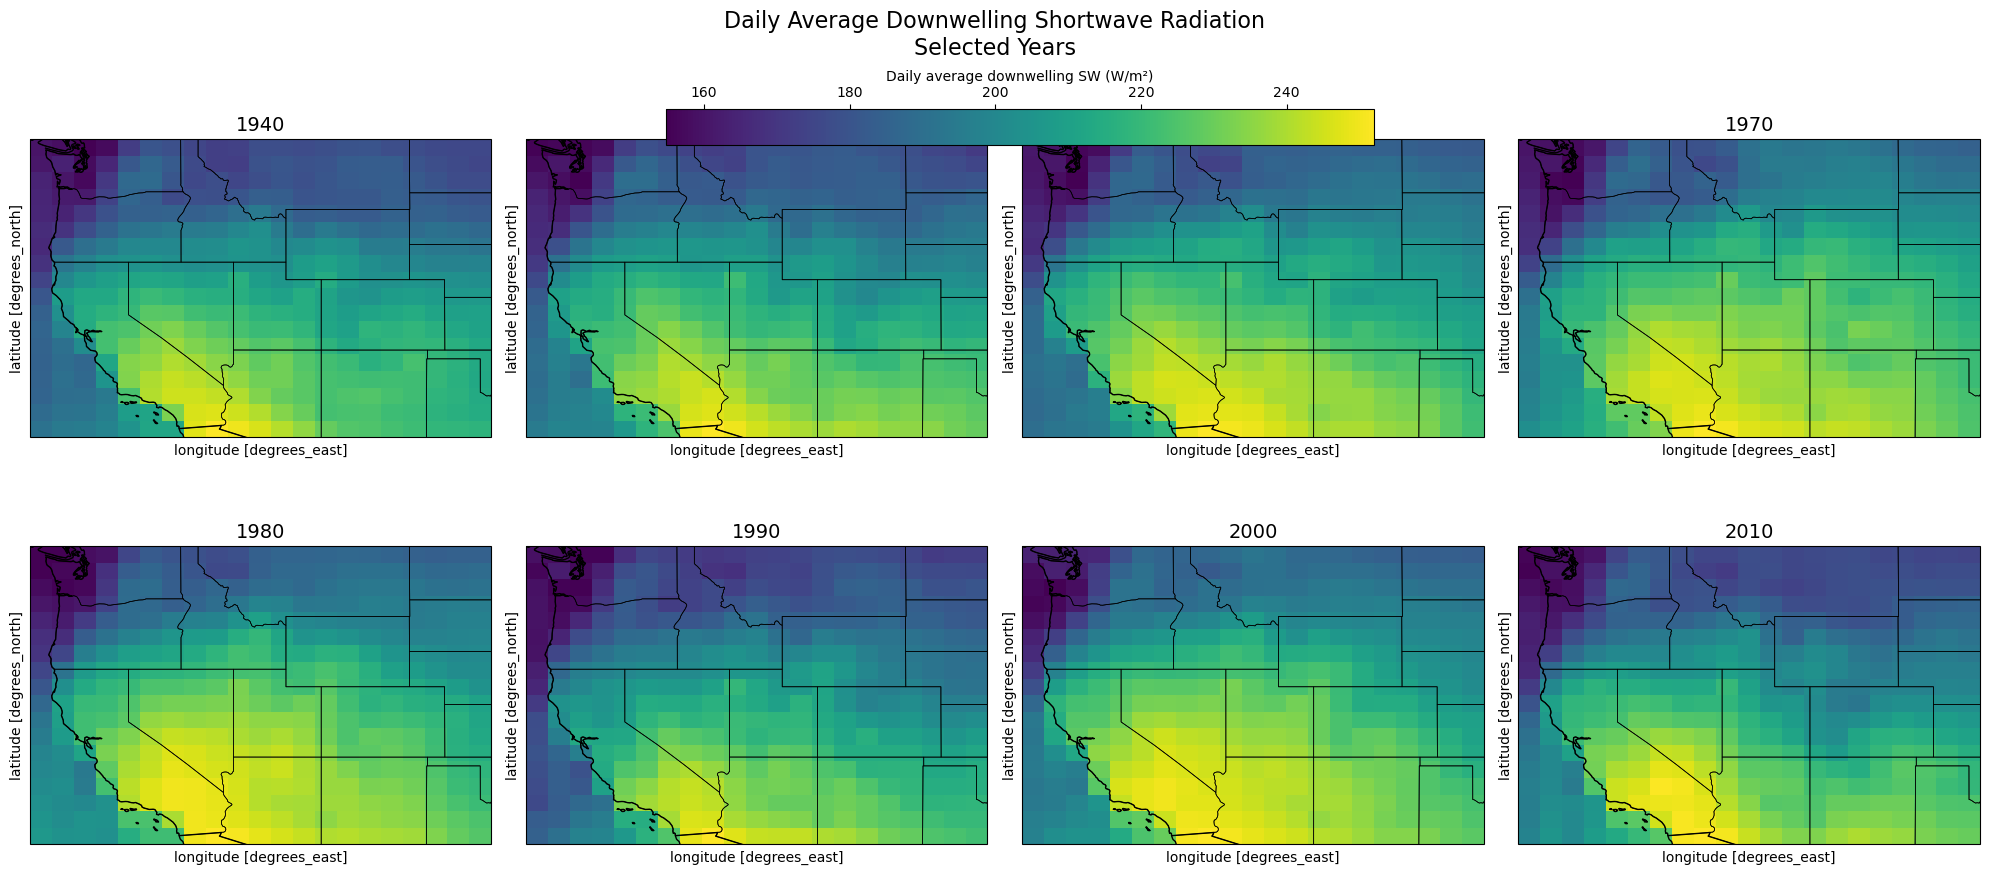

In [39]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import zarr

# 1. Open the Zarr store
zarr_path = r"D:\Downloads\CESM2_r2i1p1f1_day_WUS_1940_2014.zarr"
store = zarr.storage.DirectoryStore(zarr_path)
ds = xr.open_zarr(store, consolidated=True)

# Years to plot
years = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

# Prepare figure: 2 rows × 4 cols
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    nrows=2, ncols=4,
    figsize=(20, 10),
    subplot_kw={'projection': proj}
)

for ax, year in zip(axes.flat, years):
    # 2. Select downwelling shortwave (rsds) for that year
    rsds_year = ds['rsds'].sel(
        time=slice(f'{year}-01-01', f'{year}-12-31')
    )
    # 3. Compute daily average over the year
    avg_rsds = rsds_year.mean(dim='time')

    # 4. Plot it
    img = avg_rsds.plot.pcolormesh(
        ax=ax,
        transform=proj,
        cmap='viridis',
        add_colorbar=False
    )
    # Overlay boundaries
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
    ax.set_title(f'{year}', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

# Shared colorbar at top, horizontal
cbar = fig.colorbar(
    img, ax=axes.ravel().tolist(),
    orientation='horizontal', fraction=0.046, pad=0.08, location='top'
)
cbar.set_label('Daily average downwelling SW (W/m²)')

fig.suptitle('Daily Average Downwelling Shortwave Radiation\nSelected Years', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

C:\Users\srira\AppData\Local\Temp\ipykernel_15644\925965110.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


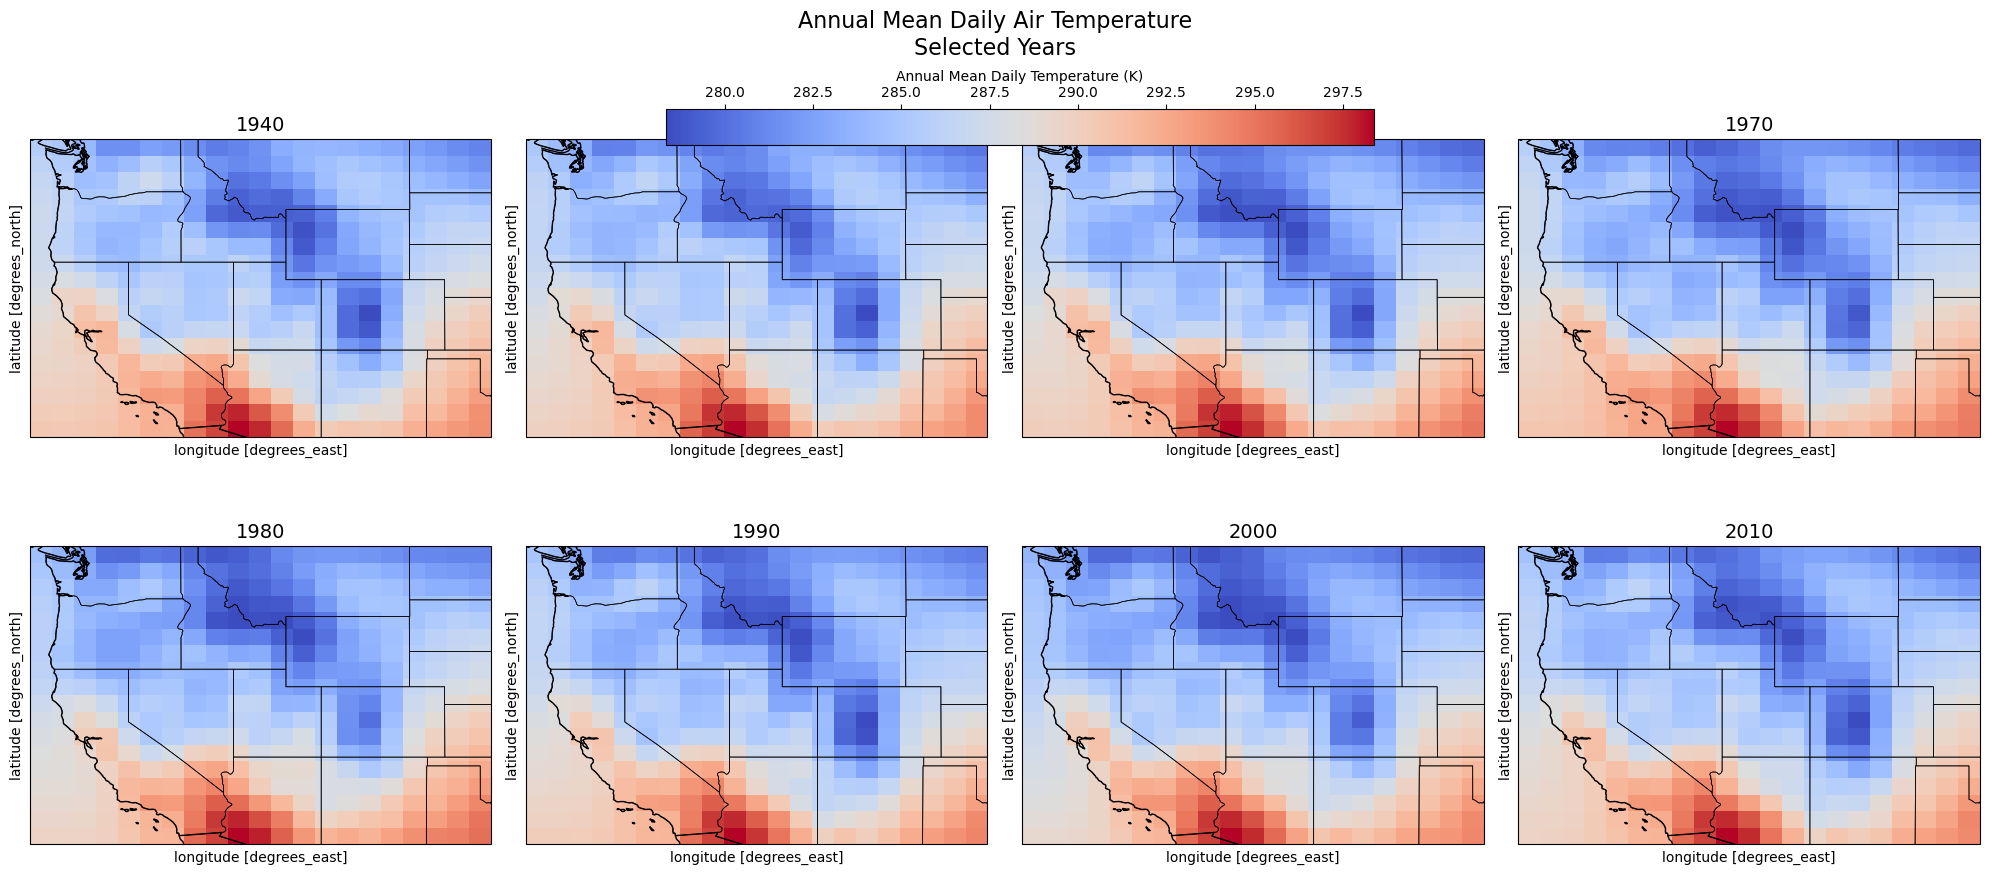

In [40]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import zarr

# 1. Open the Zarr store
zarr_path = r"D:\Downloads\CESM2_r2i1p1f1_day_WUS_1940_2014.zarr"
store = zarr.storage.DirectoryStore(zarr_path)
ds = xr.open_zarr(store, consolidated=True)

# Years to plot
years = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

# Prepare figure: 2 rows × 4 cols
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    nrows=2, ncols=4,
    figsize=(20, 10),
    subplot_kw={'projection': proj}
)

for ax, year in zip(axes.flat, years):
    # Select near-surface air temperature (tas) for that year
    tas_year = ds['tas'].sel(
        time=slice(f'{year}-01-01', f'{year}-12-31')
    )
    # Compute annual mean of daily temperature
    mean_tas = tas_year.mean(dim='time')

    # Plot it
    img = mean_tas.plot.pcolormesh(
        ax=ax,
        transform=proj,
        cmap='coolwarm',
        add_colorbar=False
    )
    # Overlay boundaries
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
    ax.set_title(f'{year}', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

# Shared colorbar at top, horizontal
cbar = fig.colorbar(
    img, ax=axes.ravel().tolist(),
    orientation='horizontal', fraction=0.046, pad=0.08, location='top'
)
cbar.set_label('Annual Mean Daily Temperature (K)')

fig.suptitle('Annual Mean Daily Air Temperature\nSelected Years', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
